# Interpret Results of Trained GCN
In this notebook, I'll try to visualize the learning of a trained GCN model. This should involve the following steps:
* Interpret the predictions made by the model
* Visualize the filters of the Graph Convolution
* Do a TSNE plot of the last layer

In [41]:
import numpy as np
import pandas as pd
#import my_gcn
import random, h5py
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gcn.models import GCN, MLP
from gcn.utils import *
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix, lil_matrix
import seaborn

import math
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
%matplotlib inline

In [42]:
model_dir = '../GCN/training/2017_12_04_15_26_18'
data_file = '../data/preprocessing/legionella_gcn_input.h5'
CLASSIFICATION_THRESHOLD = 0.7

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [43]:
# load predictions
predictions = pd.DataFrame.from_csv(model_dir + '/predictions.tsv', sep='\t', header=0)
print (predictions.sum(axis=0))
pos_predicted = predictions[predictions.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'name']).drop('ID', axis=1)
labels_df['label'] = (y_train[:,0] | y_test[:,0])
labels_df['train_label'] = y_train[:, 0]
labels_df['test_label'] = y_test[:, 0]

# show the ones that are most confidently predicted
print ("Predicted {} genes to be involved in infection".format(pos_predicted.shape[0]))
pos_predicted.sort_values(by='Prob_pos', ascending=False).to_csv('../data/GCN/gcn_positive_prediction.txt', sep='\t')
pos_predicted.sort_values(by='Prob_pos', ascending=False)[:20]

Name        TSPAN6DPM1SCYL3FGRCFHGCLCNFYALAS1LSEMA3FCFTRCY...
Prob_pos                                             4762.448
Prob_neg                                             6060.552
dtype: object
Predicted 1171 genes to be involved in infection


,Name,Prob_pos,Prob_neg
ID,,,
ENSG00000184205,TSPYL2,0.999,0.001
ENSG00000142871,CYR61,0.999,0.001
ENSG00000109846,CRYAB,0.999,0.001
ENSG00000198576,ARC,0.998,0.002
ENSG00000187140,FOXD3,0.998,0.002
ENSG00000120885,CLU,0.998,0.002
ENSG00000013588,GPRC5A,0.998,0.002
ENSG00000178381,ZFAND2A,0.998,0.002
ENSG00000173110,HSPA6,0.998,0.002


In [44]:
labels_with_pred = labels_df.join(predictions)
predictions_for_knowns = labels_with_pred[labels_with_pred.label == 1]
pos_pred = predictions_for_knowns[predictions_for_knowns.Prob_pos > CLASSIFICATION_THRESHOLD]
known_pos_predictions = pos_pred.shape[0]
number_of_knowns = predictions_for_knowns.shape[0]
pred_test = pos_pred[pos_pred.test_label == 1]
pred_train = pos_pred[pos_pred.train_label == 1]

print ("Predicted {} out of {} known infection genes".format(known_pos_predictions,
                                                             number_of_knowns)
      )
print ("Out of these {}, {} were not shown during training.".format(number_of_knowns,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_train.shape[0]/y_train[:,0].sum()*100.)
      )
predictions_for_knowns.sort_values(by='Prob_pos', ascending=False)

Predicted 27 out of 38 known infection genes
Out of these 38, 16 were not shown during training.
Predicted 11 out of 16 test genes (68.75%)
Predicted 16 out of 22 train genes (72.72727272727273%)


,name,label,train_label,test_label,Name,Prob_pos,Prob_neg
ENSG00000184205,TSPYL2,1,0,1,TSPYL2,0.999,0.001
ENSG00000149257,SERPINH1,1,0,1,SERPINH1,0.996,0.004
ENSG00000160570,DEDD2,1,0,1,DEDD2,0.995,0.005
ENSG00000099860,GADD45B,1,0,1,GADD45B,0.994,0.006
ENSG00000087074,PPP1R15A,1,1,0,PPP1R15A,0.990,0.010
ENSG00000004478,FKBP4,1,1,0,FKBP4,0.989,0.011
ENSG00000086061,DNAJA1,1,0,1,DNAJA1,0.987,0.013
ENSG00000013441,CLK1,1,1,0,CLK1,0.986,0.014
ENSG00000144381,HSPD1,1,0,1,HSPD1,0.985,0.015
ENSG00000105993,DNAJB6,1,0,1,DNAJB6,0.983,0.017


## Do the predictions have special properties?
I want to check the shortest path between predicted disease genes and true disease genes as well.
Further, I want to see them in a network.

In [ ]:
# build networkx graph with correct node names
G = nx.from_numpy_matrix(network)
mapping = {i:node_names[i, 0] for i in range(node_names.shape[0])}
nx.relabel_nodes(G, mapping, copy=False)

### Shortest Paths

In [100]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_shortest_paths = nx.shortest_path_length(G)
sp_df = pd.DataFrame(all_shortest_paths)

# build views for label to label shortest paths and non-label to non-label
label_cond = sp_df.index.isin(predictions_for_knowns.index)
label_to_label = sp_df.loc[label_cond, label_cond]
nonlabel_to_nonlabel = sp_df.loc[~label_cond, ~label_cond]
label_to_nonlabel = sp_df.loc[~label_cond, label_cond]
label_to_nonlabel.dropna(axis=0, inplace=True)

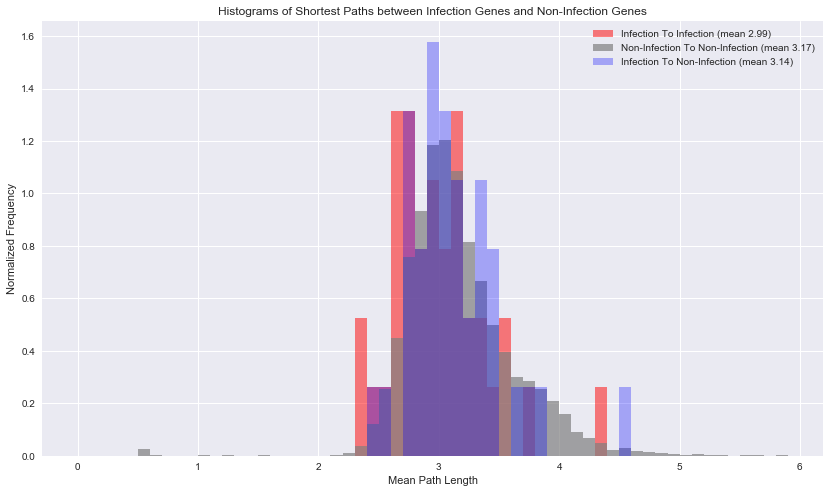

In [232]:
# plot the distributions
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 6, .1)
plt.hist(label_to_label.mean(), bins=bins, alpha=.5, normed=True, color='red',
         label='Infection To Infection (mean {0:.2f})'.format(label_to_label.mean().mean()))
plt.hist(nonlabel_to_nonlabel.mean(), bins=bins, alpha=.7, normed=True, color='gray',
         label='Non-Infection To Non-Infection (mean {0:.2f})'.format(nonlabel_to_nonlabel.mean().mean()))
plt.hist(label_to_nonlabel.mean(axis=0), bins=bins, alpha=.3, normed=True, color='blue',
         label='Infection To Non-Infection (mean {0:.2f})'.format(label_to_nonlabel.mean().mean()))
plt.legend()
plt.title('Histograms of Shortest Paths between Infection Genes and Non-Infection Genes')
plt.xlabel('Mean Path Length')
plt.ylabel('Normalized Frequency')

### Node Degree

(38,) (10785,)


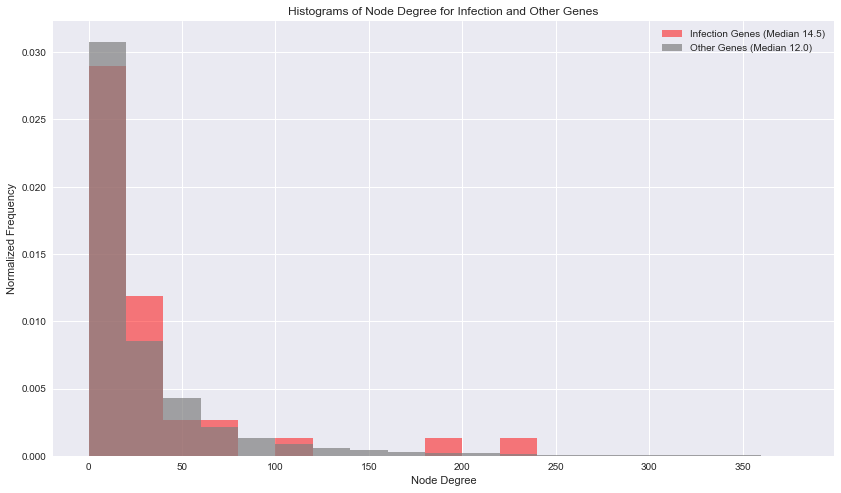

In [222]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_node_degrees = G.degree()
degree_df = pd.Series(all_node_degrees)

# build views for label and non-label degrees
label_cond = degree_df.index.isin(predictions_for_knowns.index)
labels = degree_df[label_cond]
nonlabels = degree_df[~label_cond]
print (labels.shape, nonlabels.shape)

# plot histograms
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 400, 20)
plt.hist(labels, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection Genes (Median {})'.format(labels.median()))
plt.hist(nonlabels, bins=bins, alpha=.7, normed=True, color='gray',
         label='Other Genes (Median {})'.format(nonlabels.median()))
plt.legend()
plt.title('Histograms of Node Degree for Infection and Other Genes')
plt.xlabel('Node Degree')
plt.ylabel('Normalized Frequency')

### Probability that Neighbor of Infection Gene is also Infection Gene

In [307]:
# half because of symmetric matrix
num_of_neighbor_labels = label_to_label[label_to_label == 1].count().sum() / 2
prob_neighbor_label = (num_of_neighbor_labels / label_to_label.shape[0]) * 100
print ("Chance of label to have labeled neighbor: {0:.2f} %".format(prob_neighbor_label))

Chance of label to have labeled neighbor: 10.53 %


In [305]:
num_label_nbs = []
num_nbs = []
for label in predictions.index:
    nbs = list(nx.all_neighbors(G, label))
    label_nbs = predictions_for_knowns.index.isin(nbs).sum()
    num_label_nbs.append(label_nbs)
    num_nbs.append(len(nbs))
num_label_nbs = np.array(num_label_nbs)
num_total_nbs = np.array(num_nbs)
print ("Number of labeled neighbors: {}".format(num_label_nbs.sum()))
print ("Number of neighbors total: {}".format(num_total_nbs.sum()))
freq = num_label_nbs.sum()/num_total_nbs.sum()
print ("Chance that neighbor is labeled: {0:.4f}".format(freq))

Number of labeled neighbors: 1193
Number of neighbors total: 329290
Chance that neighbor is labeled: 0.0036


## Visualize the Filters

In [5]:
flags = tf.app.flags
FLAGS = flags.FLAGS

flags.DEFINE_float('learning_rate', 0.005, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 60, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 20, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.6, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 30, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 2, 'Maximum Chebyshev polynomial degree.')
flags.DEFINE_bool('cheby', True, 'Using Chebyshev convolutions or not.')

In [6]:
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)
support = chebyshev_polynomials(adj, FLAGS.max_degree)
print (len(support))
print ([s[2] for s in support])

Calculating Chebyshev polynomials up to order 2...
3
[(10823, 10823), (10823, 10823), (10823, 10823)]


In [7]:
tf.reset_default_graph()

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(1+FLAGS.max_degree)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant((9991, 24), dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, 2)),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

weights_layer_0 = []
weights_layer_1 = []
with tf.Session() as sess:
    model = GCN(placeholders, input_dim=24, logging=True)
    model.load(sess)
    for k in range(FLAGS.max_degree): # chebychev coefficients
        mat_name = 'gcn/graphconvolution_{}_vars/weights_{}:0'.format(1, k)
        weights_layer_0.append(model.vars[mat_name].eval())
        mat_name = 'gcn/graphconvolution_{}_vars/weights_{}:0'.format(2, k)
        weights_layer_1.append(model.vars[mat_name].eval())
    
    # predict for test set and catch activations in H_1, H_2
    feed_dict = construct_feed_dict(features=F,
                                    support=support,
                                    labels=y_train,
                                    labels_mask=train_mask,
                                    placeholders=placeholders
                                   )
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    #l = sess.run(model.loss, feed_dict=feed_dict)
    activation_0 = sess.run(model.activations[-2], feed_dict=feed_dict)
    activation_1 = sess.run(model.activations[-1], feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from tmp/gcn.ckpt
Model restored from file: tmp/gcn.ckpt


In [8]:
activation_1.shape

(10823, 2)

(24, 20)


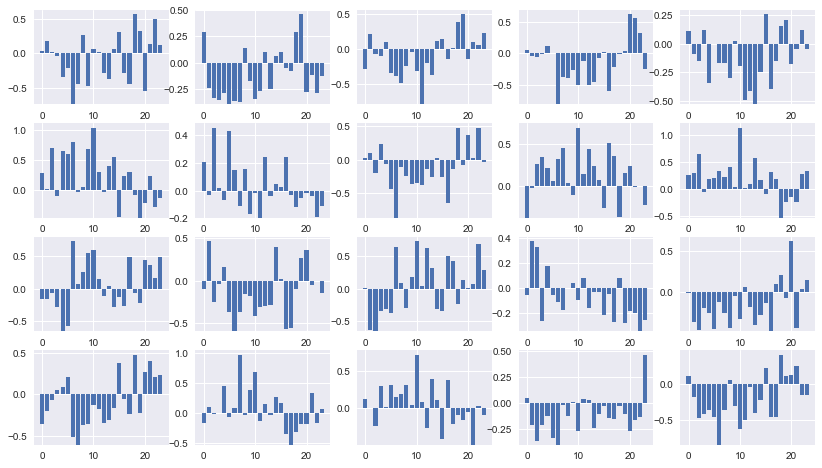

In [20]:
def plot_weights_for_k(matrix, fname='kernel_activation'):
    fig = plt.figure(figsize=(14, 8))
    num_rows, num_cols = bestSplit(matrix.shape[1])
    for i in range(matrix.shape[1]):
        plt.subplot(num_rows, num_cols, i+1)
        plt.bar(np.arange(0, matrix.shape[0]), matrix[:, i])
    fig.savefig('{}/{}.png'.format(model_dir, fname))

weights_l0_sum = np.sum(weights_layer_0, axis=0)
print (weights_l0_sum.shape)
plot_weights_for_k(weights_l0_sum, 'filters_layer0_k0')

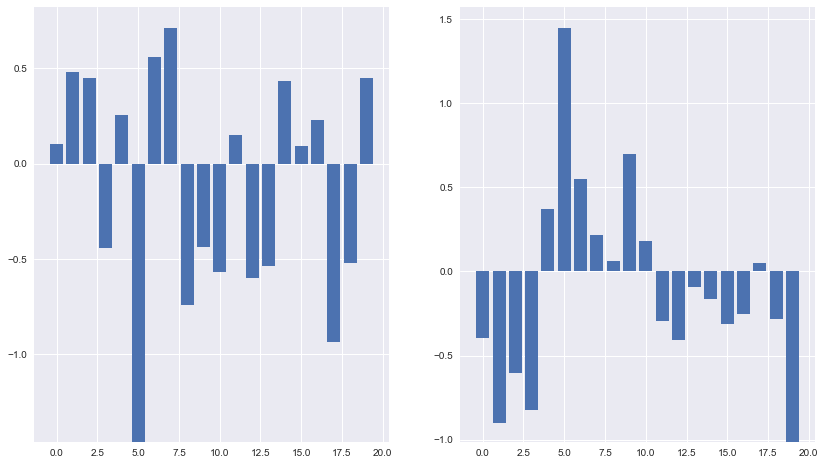

In [21]:
weights_l1_sum = np.sum(weights_layer_1, axis=0)
plot_weights_for_k(weights_l1_sum, 'filters_layer1_sum')

## Visualize the activations
Next, I want to see if the activations cluster together, that is if the output from each of the layers is embedded nicely.

In [11]:
predictions.head()

,Name,Prob_pos,Prob_neg
ID,,,
ENSG00000000003,TSPAN6,0.999,0.001
ENSG00000000419,DPM1,0.583,0.417
ENSG00000000457,SCYL3,0.221,0.779
ENSG00000000938,FGR,0.429,0.571
ENSG00000000971,CFH,0.040,0.960


In [12]:
preds_and_labels = labels_df.join(predictions)
pos_classified = preds_and_labels.Prob_pos >= CLASSIFICATION_THRESHOLD

# set the colors according to classes
preds_and_labels['color'] = 'gray'
preds_and_labels.loc[pos_classified, 'color'] = 'red'
preds_and_labels.loc[~preds_and_labels.label & pos_classified, 'color'] = 'green'
preds_and_labels.groupby('color').count()

,name,label,train_label,test_label,Name,Prob_pos,Prob_neg
color,,,,,,,
gray,10272,10272,10272,10272,9440,9440,9440
green,528,528,528,528,528,528,528
red,23,23,23,23,23,23,23


In [22]:
H_1_2d = TSNE(n_components=2).fit_transform(activation_0)

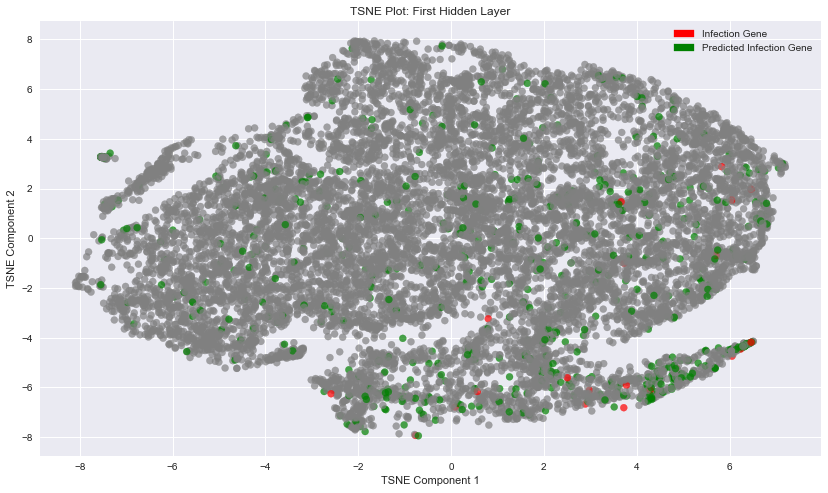

In [23]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_1_2d[:, 0], H_1_2d[:, 1], c=preds_and_labels.color, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot: First Hidden Layer')

# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
plt.legend(handles=[inf_genes, pred_genes])

# save
fig.savefig(model_dir + '/tsne_H1.png', dpi=300)

In [24]:
H_2_2d = TSNE(n_components=2).fit_transform(activation_1)

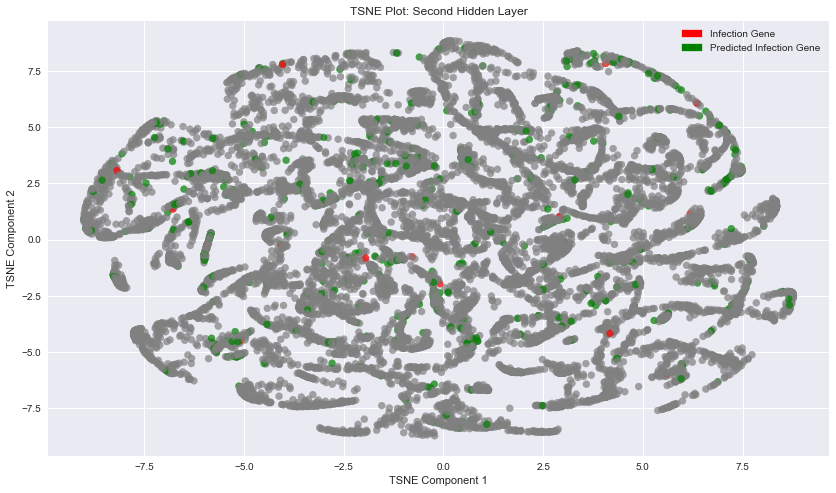

In [25]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_2_2d[:, 0], H_2_2d[:, 1], c=preds_and_labels.color, alpha=.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot: Second Hidden Layer')
# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
plt.legend(handles=[inf_genes, pred_genes])
# save
fig.savefig(model_dir + '/tsne_H2.png', dpi=300)

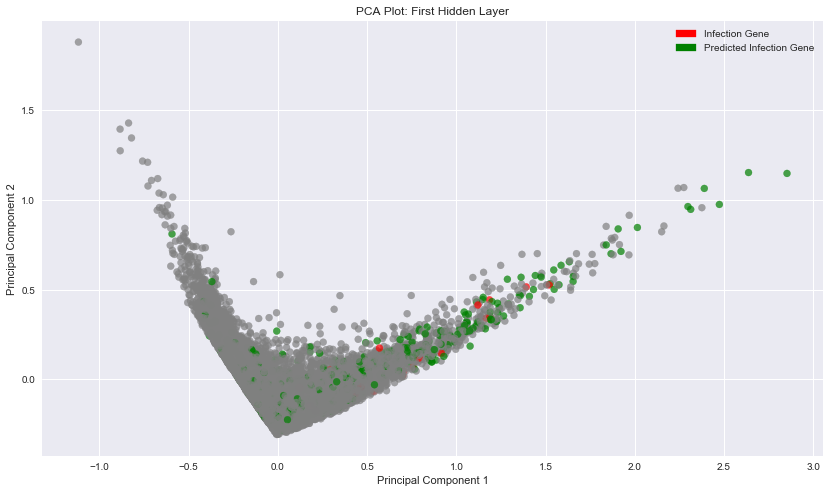

In [26]:
H_1_pca = PCA(n_components=2).fit_transform(activation_0)
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_1_pca[:, 0], H_1_pca[:, 1], c=preds_and_labels.color, alpha=.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot: First Hidden Layer')
# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
plt.legend(handles=[inf_genes, pred_genes])
# save
fig.savefig(model_dir + '/pca_H1.png', dpi=300)

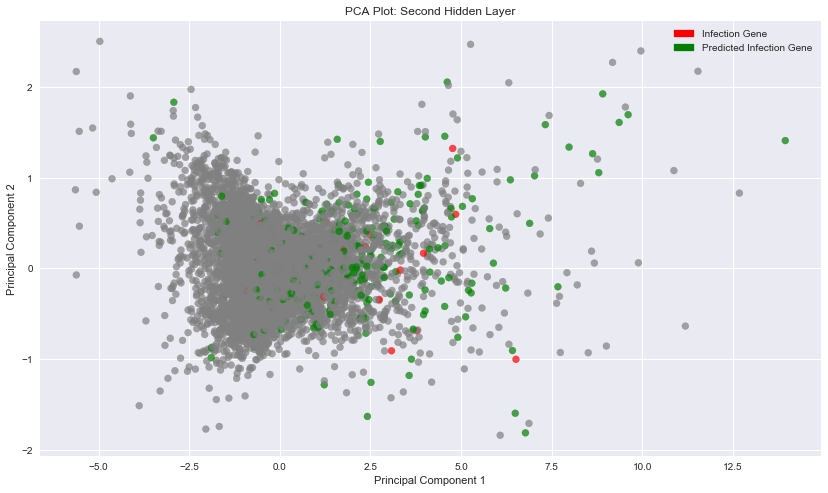

In [27]:
H_2_pca = PCA(n_components=2).fit_transform(activation_1)
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_2_pca[:, 0], H_2_pca[:, 1], c=preds_and_labels.color, alpha=.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot: Second Hidden Layer')
# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
plt.legend(handles=[inf_genes, pred_genes])
# save
fig.savefig(model_dir + '/pca_H2.png', dpi=300)

## Correlation with other methods
I will now try to see how similar my performance is to NetRank and PageRank.

In [29]:
netrank_scores = pd.DataFrame.from_csv('../data/pagerank/netrank_scores.txt', header=0, sep='\t')
netrank_scores.rename(columns={'Rank': 'NetRank_Rank'})
predictions.sort_values('Prob_pos', ascending=False, inplace=True)
predictions['GCN_Rank'] = np.arange(1, predictions.shape[0]+1)
print ("Correlation Rank & Prob: {}".format(predictions.Prob_pos.corr(predictions.GCN_Rank)))

Correlation Rank & Prob: -0.8933735762570131


(10823, 4) (10823, 3)


AttributeError: 'DataFrame' object has no attribute 'Rank'

Correlation between NetRank and GCN: 0.22720775512979755


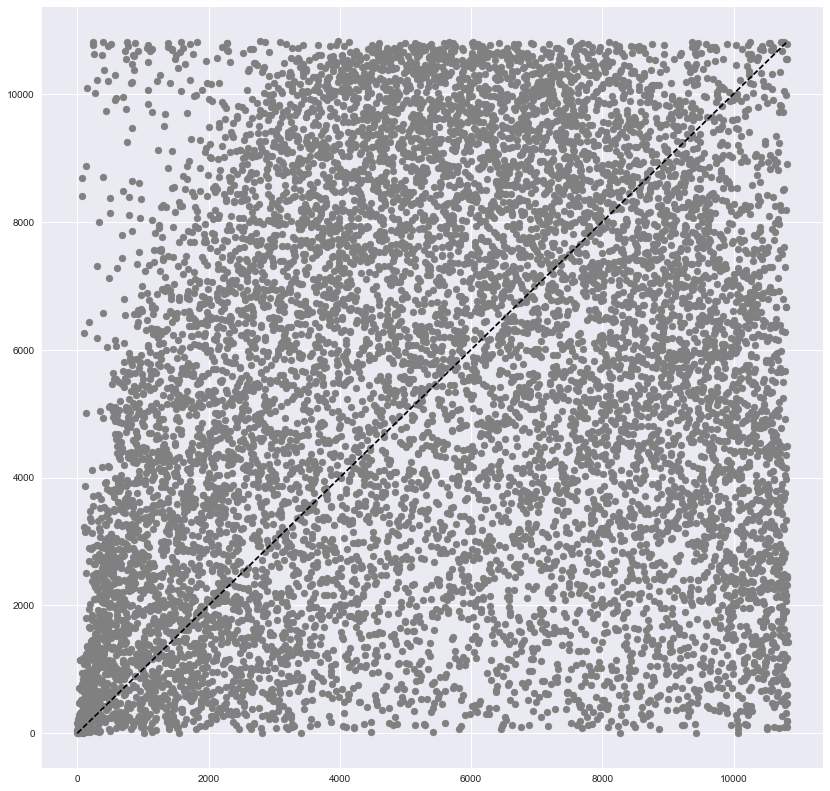

In [33]:
netrank_with_predictions = predictions.join(netrank_scores, how='inner')
fig = plt.figure(figsize=(14, 14))
plt.scatter(netrank_with_predictions.GCN_Rank, netrank_with_predictions.Rank, color='gray')
lin = np.arange(1, netrank_with_predictions.shape[0]+1)
plt.plot(lin, lin, '--', color='black')

print ("Correlation between NetRank and GCN: {}".format(netrank_with_predictions.Rank.corr(netrank_with_predictions.GCN_Rank)))

In [37]:
netrank_scores.head()

,Gene_Name,Rank,NetRank_Score
Gene_ID,,,
ENSG00000173110,HSPA6,1,0.348
ENSG00000109846,CRYAB,2,0.102
ENSG00000166592,RRAD,3,0.028
ENSG00000188290,HES4,4,0.013
ENSG00000204389,HSPA1A,5,0.011
